## Neural Computing Coursework
### Dimitrios Megkos - 210034034 - dimitrios.megkos@city.ac.uk
### A Comparison of MLP and CNN in Predicting Noisy Handwritten Digits

### Library Imports

In [1]:
# general imports
import numpy as np
# dataset import
from torchvision.datasets import MNIST
# image augmentation imports
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomRotation
from torchvision.transforms import RandomErasing
from torchvision.transforms import GaussianBlur
# neural networks imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
# custom functions imports
from customMLP import CustomMLP, train_val_MLP, train_final_MLP, test_MLP, predict_digit_MLP
from customCNN import CustomCNN, train_val_CNN, train_final_CNN, test_CNN, predict_digit_CNN
# set torch manual seed for the random transformations
torch.manual_seed(10)

### 1. Description and Motivation
Image classification is one of the most fundamental tasks in computer vision. It has contributed greatly to the advancement of many fields like identifying cancer cells in healthcare, self-driving cars in the automobile industry, biometric authentication in computer science, and more [1].

The purpose of this exercise is to build and optimize two supervised learning neural networks in order to compare their performance on the classification of handwritten digits. The best performing algorithm could be applied in a "real world" scenario, such as recognizing and automatically converting handwritten digits that are written using a stylus and an input device, or taking a picture of a handwritten phone number with a smartphone, and then using that picture to call the number.

### 2. Dataset
The Neural Networks are going to be trained and tested on datasets based on the MNIST (Modified National Institute of Standards and Technology) Database. This is a large database containing images of handwritten digits, that were normalized to fit into a 28x28 pixel box and anti-aliased, which introduced grayscale levels [2]. Each image contains one channel, the grayscale channel, having a distinct number from 0 to 255. The database contains 60,000 training images and 10,000 testing images. The digits were drawn by employees of the American Census Bureau and by American high school students.

In order to add complexity to the problem and create more robust algorithms, extra noise is going to be applied on the training set. First, a random rotation between zero and thirty degrees will be applied to the digits, inspired by slanted handwriting. Second, random pixel erasing will be applied to the images to further push the limits of the neural networks [3].

For the final testing of the neural network, two versions of the MNIST test set will be used, a clean set with zero noise and a noisy set with GaussianBlur.

#### Load the Dataset
The dataset is included in the TorchVision Datasets library and can be imported using the class MNIST. This is a handy way of getting the MNIST data because the train and test sets can be loaded straight into datasets while also applying various transformations to the data, like normalizing, transforming to tensors, and adding noise. 

In [2]:
# download MNIST data using TorchVision and apply augmentations
# train set
mnist_ftrain = MNIST(root='./data', train=True, download=True, transform=Compose([ToTensor(),RandomRotation(degrees=(0, 30)),RandomErasing(scale=(0.01, 0.1), ratio=(0.2, 2.0)),Normalize((0.1307,), (0.3081,))]))
# clean test set
mnist_ctest = MNIST(root='./data', train=False, download=True, transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))]))
# blurry test set
mnist_btest = MNIST(root='./data', train=False, download=True, transform=Compose([ToTensor(),GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 4)),Normalize((0.1307,), (0.3081,))]))

#### Create a validation set using the training set
A validation set is created using 20% of the training set. The validation set will be used after training the model in order to experiment with different model parameters. The test sets will be used in the end, as a final test on the optimised model.

In [3]:
# apply a 80-20 random split on the training set in order to create a validation set
mnist_train, mnist_validation = random_split(mnist_ftrain, [int(0.8 * len(mnist_ftrain)), int(0.2 * len(mnist_ftrain))])

#### Checking for Class Imbalance

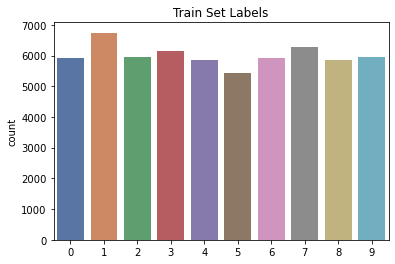

In [4]:
# train set
cp=sns.countplot(x=np.array(mnist_train.dataset.targets),palette='deep').set(title='Train Set Labels')
#plt.savefig('class_balance.png')

#### Preparing the data for training with DataLoaders
Due to the big size of the dataset, batch learning is going to be used for the update of weights since it's more stable than online learning. Typically, while a model is being trained, it's recommended to pass samples in “minibatches”, reshuffling the data at every epoch to reduce model overfitting. PyTorch's DataLoader is the answer for parallelizing the data loading process with automatic batching [4].

In [5]:
# setting a fixed batch_size
batch_size = 64
# setting the number of iterations
n_iters = 5000
# calculating the number of epochs
n_epochs = n_iters / (len(mnist_train) / batch_size)
n_epochs = int(n_epochs)
# calculating number of epochs for full set
fn_epochs = n_iters / (len(mnist_ftrain) / batch_size)
fn_epochs = int(fn_epochs)
# creating the dataloaders
ftrain_dataloader = DataLoader(mnist_ftrain, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)
ctest_dataloader = DataLoader(mnist_ctest, batch_size=batch_size, shuffle=False)
btest_dataloader = DataLoader(mnist_btest, batch_size=batch_size, shuffle=False)

#### Visualising a few digits
A number of digits can be visualised by unpacking a batch from the dataloaders and plotting them with imshow, showing all the applied image augmentations.

#### Train Dataloader

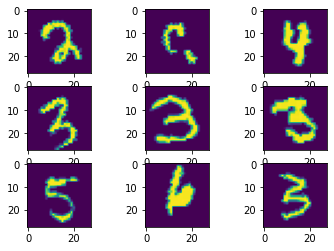

In [6]:
# get a batch of images
i, (images, labels) = next(enumerate(train_dataloader))
# plot nine images
for i in range(9):
    # create the subplot
    plt.subplot(3,3,i+1)
    # plot the data
    plt.imshow(images[i][0])
#plt.savefig('augmented_train.png')
# show images
fig=plt.show()

#### Clean Test Dataloader

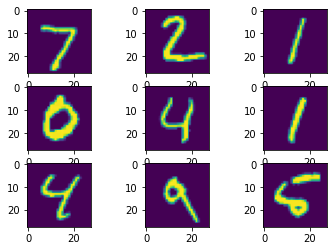

In [7]:
# get a batch of images
i, (cimages, clabels) = next(enumerate(ctest_dataloader))
# plot nine images
for i in range(9):
    # create the subplot
    plt.subplot(3,3,i+1)
    # plot the data
    plt.imshow(cimages[i][0])
#plt.savefig('clean_test.png')
# show images
plt.show()

#### Blurred Test Dataloader

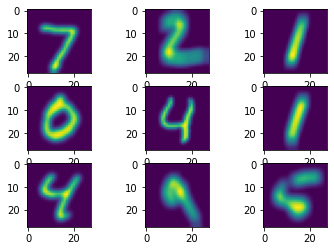

In [8]:
# get a batch of images
i, (bimages, blabels) = next(enumerate(btest_dataloader))
# plot nine images
for i in range(9):
    # create the subplot
    plt.subplot(3,3,i+1)
    # plot the data
    plt.imshow(bimages[i][0])
#plt.savefig('noisy_test.png')
# show images
plt.show()

### 3. Models: Multilayer Perceptron (MLP) and Convolutional Neural Network (CNN)

The two models that are going to be used for this classification problem are Multilayer Perceptron (MLP) and Convolutional Neural Network (CNN). Both models can provide a lot of flexibility due to having a number of hyperparameter optimization options, making both really powerful and reliable in a wide range of problems.

#### Hypothesis Statement
a) Both models will have a high accuracy despite the added noise on the test dataset. However, Convolutional Neural Network will perform better than Multilayer Perceptron, especially on the blurry test set, since the algorithm was designed specifically for image recognition.

b) Convolutional Neural Network will require significantly longer time to train than Multilayer Perceptron, because of the added convolution and pooling layers.

#### Multilayer Perceptron (MLP)

Multilayer Perceptrons are considered the classical type of neural networks. They are an extension of the first trainable Artificial Neural Network, the Perceptron, adding extra hidden layers consisting of multiple hidden neurons between the input and the output layers. The input data is received by the input layer, which is then passed through the hidden layers, the computational engine of the network. Finally, the prediction and classification is performed by the output layer. The network is trained using backpropagation, a method which updates the weights of the neuron connections based on the output error or loss. A Multilayer Perceptron with even just one hidden layer can approximate any function that contains a continuous mapping from one finite space to another [9].

Pros:

- Easy to implement and train
- Suitable for both classification and regression tasks
- Capable of learning any mapping function and have been proven to be a universal approximation algorithm
- Can be applied to many types of data (image data, text data, time series data) as long as data is provided in a tabular format

Cons:

- Falls behind in advanced computer vision tasks, because it takes flattened vectors as inputs, disregarding the spatial relationships of images
- Sensitive to feature scaling
- Supervised learning only algorithm

#### Multilayer Perceptron Choice of Parameters

Number of hidden layers: Since the given classification problem is an image recognition problem, it was decided from the start that the network will have two hidden layers. A Multilayer Perceptron with two hidden layers can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy [9].

Activation function: The activation function that was chosen is the Rectified linear Activation Function (ReLU). ReLU will output the input directly if it is positive, otherwise, it will output zero. It is a nonlinear function that looks and acts like a linear function, and is the default activation function for most types of neural networks.

Loss function and output layer activation: For classification problems, cross entropy is used as a loss function. Since this is a multiclass classification problem and the output layer has multiple neurons (one for each class), a softmax activation function was used to output the probability of the network predicting each of the class values. The class with the highest probability was selected in the end as the predicted class.

Weights initialization: The weights were initialized using He initialization [5] and Glorot initialization [6]. 

#### Initialize parameters that control the architecture or topology of the network
Input dimension: The input layer has 784 neurons, which are the pixel values of each image with size 28 by 28.

Output dimension: The output dimension has 10 neurons, one for each class the algorithm is trying to predict.

Hidden dimension: The number of neurons in the hidden layer was decided after experimentation.

In [33]:
# the number of pixels of each image
mlp_input_dim = 28*28
# predict one of ten digits (0-9)
mlp_output_dim = 10
# the number of neurons in the hidden layers
mlp_hidden_dim = 200

#### Initialize parameters that control the optimization of the network

In [34]:
# Error/Loss function
mlp_criterion = nn.CrossEntropyLoss()
# Optimizer
mlp_learning_rate = 0.01 # the learning rate
mlp_optimizer = "SGD" # use Stochastic Gradient Descent
#mlp_optimizer = "Adam" # use Adam optimizer

#### Initialize variables for accuracy metrics

In [35]:
mlp_count = 0
mlp_loss_lst = []
mlp_iteration_lst = []
mlp_accuracy_lst = []

#### Create the MLP model
Calling the CustomMLP class creates the Multilayer Perceptron network with the given input, hidden, and output dimensions.

In [36]:
# Create the Multilayer Perceptron Neural Network
model_MLP = CustomMLP(mlp_input_dim, mlp_hidden_dim, mlp_output_dim)

#### Training and evaluation experimentation
Calling the train_val_MLP function trains and evaluates the CustomMLP on the given train and validation dataloaders, using the hyperparameter values that are passed to the function. Performance metrics are returned in the end of the training and evaluation. This function is used to experiment and test different hyperparameter values.

Iteration: 500  Loss: 1.651993751525879  Accuracy: 86.5 %
Iteration: 1000  Loss: 1.5677711963653564  Accuracy: 89.0999984741211 %
Iteration: 1500  Loss: 1.5375105142593384  Accuracy: 90.0999984741211 %
Iteration: 2000  Loss: 1.5271657705307007  Accuracy: 91.33333587646484 %
Iteration: 2500  Loss: 1.5487436056137085  Accuracy: 92.06666564941406 %
Iteration: 3000  Loss: 1.5734336376190186  Accuracy: 92.625 %
Iteration: 3500  Loss: 1.541494369506836  Accuracy: 93.33333587646484 %
Iteration: 4000  Loss: 1.5237689018249512  Accuracy: 93.84166717529297 %
Iteration: 4500  Loss: 1.5371241569519043  Accuracy: 93.9749984741211 %


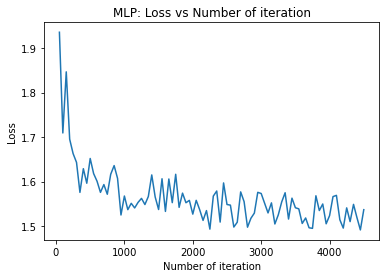

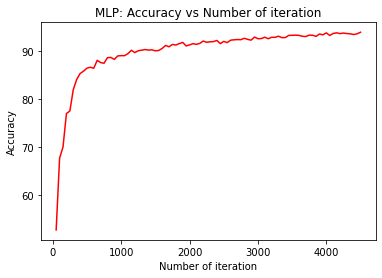

In [13]:
# Train the model and return accuracy and loss-accuracy graphs
train_val_MLP(train_dataloader,val_dataloader,model_MLP,mlp_criterion,mlp_optimizer,mlp_learning_rate,n_epochs,mlp_count,mlp_loss_lst,mlp_iteration_lst,mlp_accuracy_lst)

#### Retrain with optimal hyperparameters
Calling the train_final_MLP function trains the CustomMLP on the combined train and validation dataloaders, using the optimal hyperparameter values.

In [37]:
# Retrain with best hyperparameters on the combined train and validation set
train_final_MLP(ftrain_dataloader,model_MLP,mlp_criterion,mlp_optimizer,mlp_learning_rate,fn_epochs)

#### Test the model on the final clean and blurry test sets
The optimized model can be tested on how good it performs on completely unseen images, using the clean test set and the blurry test set.

Accuracy: 94%


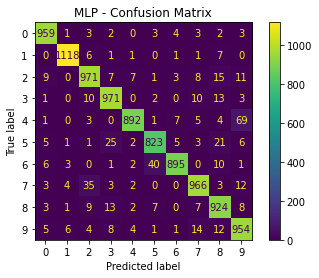

In [38]:
# Test the model on the clean test set
test_MLP(ctest_dataloader,model_MLP)

Accuracy: 90%


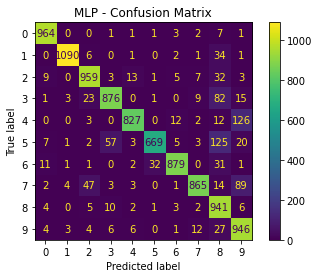

In [40]:
# Test the model on the blurry test set
test_MLP(btest_dataloader,model_MLP)

#### Predict a specific number
A single prediction can be made by passing a specific row of the clean and blurry test set to the optimized MLP model.

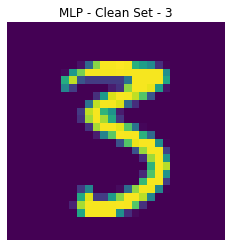

Predicted the number 3


In [82]:
# clean test data
# the index to pass for prediction - controls which number will be passed
pred_idx = 1600
# visualize one of the images in the test data set
plt.imshow(mnist_ctest[pred_idx][0][0])
plt.axis("off")
plt.title('MLP - Clean Set - '+str(mnist_ctest[pred_idx][1]))
plt.show()

# Predict a number based on the pixel values
predict_digit_MLP(mnist_ctest[pred_idx][0],model_MLP)

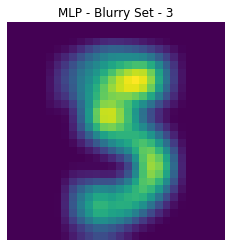

Predicted the number 3


In [81]:
# blurry test data
# the index to pass for prediction - controls which number will be passed
pred_idx = 1600
# visualize one of the images in the test data set
plt.imshow(mnist_btest[pred_idx][0][0])
plt.axis("off")
plt.title('MLP - Blurry Set - '+str(mnist_btest[pred_idx][1]))
plt.show()

# Predict a number based on the pixel values
predict_digit_MLP(mnist_btest[pred_idx][0],model_MLP)

#### Convolutional Neural Network (CNN)
Convolutional Neural Networks were designed to map images to an output variable, and they are the preferred method for image recognition problems. They introduce a number of convolution and pooling layers that preprocess the images before passing them to traditional feed forward neural networks. A full image is given as an input to the model, the convolution layer applies a filter (kernel) on top of the image computing the dot product. The output is collected in a feature map which is used as an input for the pooling layer. A pooling layer is a technique that is used to compress feature representations and reduce overfitting [8]. The output of the pooling layer is flattened and passed as input vector to a normal feed forward neural network. A Convolutional Neural Network can have multiple convolution and pooling layers and multiple hidden layers in the feed forward network.

Pros:
- Suitable for both classification and regression problems
- Can preserve the spatial relationship of data, making them ideal for image classification problems
- They can automatically learn and generalize features
- Designed to be invariant to object position and distortion in the scene

Cons:
- Can take a longer time to train than normal feed forward networks due to the greater number of computations
- Has increased complexity due to the extra convolution and pooling layers
- Supervised learning only algorithm

#### Convolutional Neural Network Choice of Parameters
Number of convolution and pooling layers: Because the images have added noise, two convolution and two pooling layers were used to better learn and generalize features.

Number of hidden layers on the fully connected network: Since the given classification problem is an image recognition problem, it was decided from the start that the network will have two hidden layers.

Activation function: The activation function that was chosen is the Rectified linear Activation Function (ReLU). ReLU will output the input directly if it is positive, otherwise, it will output zero. It is a nonlinear function that looks and acts like a linear function, and is the default activation function for most types of neural networks.

Loss function and output layer activation: For classification problems, cross entropy is used as a loss function. Since this is a multiclass classification problem and the output layer has multiple neurons (one for each class), a softmax activation function was used to output the probability of the network predicting each of the class values. The class with the highest probability was selected in the end as the predicted class.

Weights initialization: The weights were initialized using He initialization [5] and Glorot initialization [6].

#### Initialize parameters that control the architecture or topology of the network
Convolution layer input dimension: The whole image is passed as input to the convolution layer, therefore the dimension was set to one.

Convolution layer number of filters: Experimentation was done using thirty-two and sixty-four filters, with the latter giving better results.

Convolution and Pooling kernel: A small kernel size (three and two respectively) was used since the dimensions of the images are small.

Output dimension of fully connected network: The output dimension has 10 neurons, one for each class the algorithm is trying to predict.

Hidden dimension of fully connected network: Decided after experimentation.

In [43]:
# convolution layer input, one image
cnn_conv_input_dim = 1
# number of convolution layer filters
cnn_conv_nfilters = 64
# convolution layer kernel
cnn_conv_kernel = 3
# pooling layer kernel
cnn_pool_kernel = 2
# the number of neurons in the hidden layers
cnn_fc_hidden_dim = 150
# predict one of ten digits (0-9)
cnn_fc_output_dim = 10

#### Initialize parameters that control the optimization of the network

In [44]:
# Error/Loss function
cnn_criterion = nn.CrossEntropyLoss()
# Optimizer
cnn_learning_rate = 0.01 # the learning rate
cnn_optimizer = "SGD" # use Stochastic Gradient Descent
#cnn_optimizer = "Adam" # use Adam optimizer

#### Initialize variables for accuracy metrics

In [45]:
cnn_count = 0
cnn_loss_lst = []
cnn_iteration_lst = []
cnn_accuracy_lst = []

#### Create the CNN Model
Calling the CustomCNN class creates the Convolutional Neural Network with the given convolution layer input dimension, number of filters, kernels, and the fully connected input, hidden, and output dimensions.

In [48]:
# Create the Convolutional Neural Network
model_CNN = CustomCNN(cnn_conv_input_dim,cnn_conv_nfilters,cnn_conv_kernel,cnn_pool_kernel,cnn_fc_hidden_dim,cnn_fc_output_dim)

#### Training and evaluation experimentation
Calling the train_val_CNN function trains and evaluates the CustomCNN on the given train and validation dataloaders, using the hyperparameter values that are passed to the function. Performance metrics are returned in the end of the training and evaluation. This function is used to experiment and test different hyperparameter values.

Iteration: 500  Loss: 1.7721948623657227  Accuracy: 67.4000015258789 %
Iteration: 1000  Loss: 1.6803432703018188  Accuracy: 76.83333587646484 %
Iteration: 1500  Loss: 1.513366460800171  Accuracy: 94.92500305175781 %
Iteration: 2000  Loss: 1.5070247650146484  Accuracy: 95.16666412353516 %
Iteration: 2500  Loss: 1.48014497756958  Accuracy: 96.03333282470703 %
Iteration: 3000  Loss: 1.507873773574829  Accuracy: 96.0999984741211 %
Iteration: 3500  Loss: 1.5209301710128784  Accuracy: 96.30833435058594 %
Iteration: 4000  Loss: 1.477222204208374  Accuracy: 96.56666564941406 %
Iteration: 4500  Loss: 1.4617489576339722  Accuracy: 96.56666564941406 %


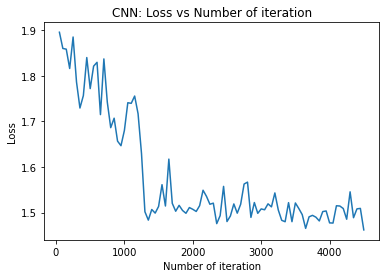

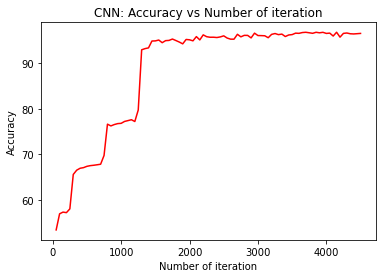

In [47]:
# Train the model and return accuracy and loss-accuracy graphs
train_val_CNN(train_dataloader,val_dataloader,model_CNN,cnn_criterion,cnn_optimizer,cnn_learning_rate,n_epochs,cnn_count,cnn_loss_lst,cnn_iteration_lst,cnn_accuracy_lst)

#### Retrain with optimal hyperparameters
Calling the train_final_CNN function trains the CustomCNN on the combined train and validation dataloaders, using the optimal hyperparameter values.

In [49]:
# Retrain with best hyperparameters on the combined train and validation set
train_final_CNN(ftrain_dataloader,model_CNN,cnn_criterion,cnn_optimizer,cnn_learning_rate,fn_epochs)

#### Test the model on the final clean and blurry test sets
The optimized model can be tested on how good it performs on completely unseen images, using the clean test set and the blurry test set.

Accuracy: 97%


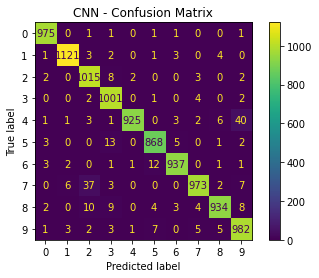

In [50]:
# Test the model on the clean test set
test_CNN(ctest_dataloader,model_CNN)

Accuracy: 90%


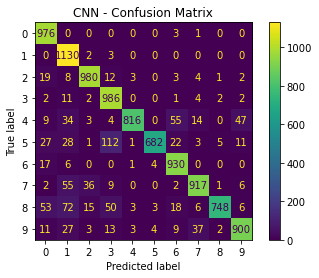

In [86]:
# Test the model on the blurry test set
test_CNN(btest_dataloader,model_CNN)

#### Predict a specific number
A single prediction can be made by passing a specific row of the clean and blurry test sets to the optimized CNN model.

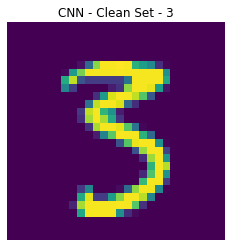

Predicted the number 3


In [80]:
# clean test data
# the index to pass for prediction - controls which number will be passed
pred_idx = 1600
# visualize one of the images in the test data set
plt.imshow(mnist_ctest[pred_idx][0][0])
plt.axis("off")
plt.title('CNN - Clean Set - '+str(mnist_ctest[pred_idx][1]))
plt.show()

# Predict a number based on the pixel values
predict_digit_CNN(mnist_ctest[pred_idx][0],model_CNN)

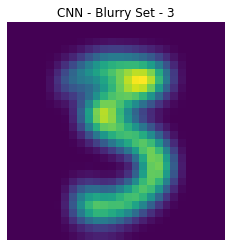

Predicted the number 3


In [79]:
# blurry test data
# the index to pass for prediction - controls which number will be passed
pred_idx = 1600
# visualize one of the images in the test data set
plt.imshow(mnist_btest[pred_idx][0][0])
plt.axis("off")
plt.title('CNN - Blurry Set - '+str(mnist_btest[pred_idx][1]))
plt.show()

# Predict a number based on the pixel values
predict_digit_CNN(mnist_btest[pred_idx][0],model_CNN)

#### 4. Experimental Results
Two different optimizers were tested for MLP: Adam with 0.001 learning rate and Stochastic Gradient Descent with 0.01 learning rate and 0.9 momentum. Three values were used for MLP’s number of neurons on the hidden layers: 100, 150, and 200. For CNN, only SGD was tested, with 150 and 200 hidden neurons and two different values of number of filters for the Convolution layer: 32 and 64.

#### Multilayer Perceptron
Using Stochastic Gradient Descent with 0.01 learning rate and 200 neurons on the hidden layers returned the best results, with an accuracy of 94%. The results of the experiments are shown on figure 5 and figure 6 below.

<img src="screenshots/figure_5_6.png" width="450" height="510">

#### Convolutional Neural Network
Using 64 filters on the convolution layer with 150 neurons on the hidden layer returned the best results, with an accuracy of 96.5%. The results of the experiments are shown on figure 7 below.

<img src="screenshots/figure_7.png" width="450" height="210">

#### 5. Analysis and critical evaluation of results
Both algorithms’ best trained models performed great on the validation set, with Multilayer Perceptron having an accuracy of 94% and Convolutional Neural Network having an accuracy of 96.5%. Although the difference in performance is small, CNN does a better job in recognising rotated numbers, numbers with random pixel erasing or a combination of both.

Both models were retrained with the best hyperparameter values using the combined sets of training and validation in order to increase the amount of training images and were tested on the clean and blurry test sets. Figure 8 below shows that both algorithms had almost no trouble recognising clean images, which had no added rotation, pixel erasing or Gaussian Blur, with MLP having an accuracy of 94% and CNN having an accuracy of 97%.

<img src="screenshots/figure_8.png" width="450" height="240">

CNN did a better job in recognising all numbers, with number one being the easiest number to recognise for both algorithms. Numbers four and seven were the ones that got the most misclassifications as both models confused them for numbers nine and two respectively, since they look somewhat similar, with MLP also confusing number six for number five.

Performance on the blurry test was a bit worse than on the clean set, as expected, but still impressively high. Figure 9 below shows that both algorithms achieved an accuracy of 90%. Comparing the confusion matrices shows that each algorithm had different weaknesses. CNN was better in recognising numbers 0, 1, 2, 3, 5, 6 and 7, while MLP was better in recognising numbers 4, 8 and 9.

<img src="screenshots/figure_9.png" width="450" height="240">

These results make sense as even the human eye has trouble identifying blurry images without the use of external help (i.e., glasses for myopia). Nevertheless, the performance is impressive, as shown in figure 10 below.

<img src="screenshots/figure_10.png" width="250" height="230">

#### Save Models and Dataloaders

#### Save Final MLP Model

In [83]:
# save the optimised MLP model
torch.save(model_MLP,'model_MLP.pth')

#### Save Final CNN Model

In [84]:
# save the optimised CNN model
torch.save(model_CNN,'model_CNN.pth')

#### Save Clean and Blurry Test Sets for Testing

In [85]:
# save the clean dataloader
torch.save(ctest_dataloader,'ctest_dataloader.pth')

# save the blurry dataloader
torch.save(btest_dataloader,'btest_dataloader.pth')

References:
- [1] Image Classification Explained: An Introduction, https://www.v7labs.com/blog/image-classification-guide
- [2] The MNIST Database of handwritten digits, http://yann.lecun.com/exdb/mnist/
- [3] Illustration of transforms, https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
- [4] Datasets & DataLoaders, https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- [5] K. He, X. Zhang, S. Ren and J. Sun, "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification," 2015 IEEE International Conference on Computer Vision (ICCV), 2015, pp. 1026-1034, doi: 10.1109/ICCV.2015.123.
- [6] Glorot, Xavier and Yoshua Bengio. “Understanding the difficulty of training deep feedforward neural networks.” AISTATS (2010).
- [7] Crash Course On Multi-Layer Perceptron Neural Networks, https://machinelearningmastery.com/neural-networks-crash-course/
- [8] Crash Course in Convolutional Neural Networks for Machine Learning, https://machinelearningmastery.com/crash-course-convolutional-neural-networks/
- [9] The Number of Hidden Layers, https://www.heatonresearch.com/2017/06/01/hidden-layers.html
- [10] A Gentle Introduction to the Rectified Linear Unit (ReLU), https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
- [11] Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791.